In [1]:
##### MODELING LIBRARIES #####
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from patsy import dmatrices, dmatrix

from sklearn.metrics import mean_squared_error, r2_score

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### TIMING AND UTILITY LIBRARIES #####
import sqlalchemy as db
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [2]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_load = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop initial null rows from missing lagged values
df_load = df_load.iloc[169:,:]

# Infill remaining nulls (from missing daylight savings hour) with previous value
backfilled = df_load.isna().sum().sum()
print('Backfilling %s null values...'%(backfilled))
df_load = df_load.fillna(method = 'backfill')

# Limit dataset to 13 months of data (18240 hours)
df_load = df_load.head(18240)

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_load[col] = df_load[col].astype('category')

Reading pre-built dataset...
Backfilling 4 null values...


In [4]:
##### LASSO REGRESSION ON TRAINING DATA #####
        
tic = timeit.default_timer()
print("\nDefining training set and creating regression model fit...") 

# Set random seed
random.seed(238)

# Use Patsy to create the one-hot encoded dummy variables with interactions 
y, X =  dmatrices('value~LoadLag+LoadLagSq+LoadLag3+Light+WWP+THI+WWPSq+THISq+WWPLag+THILag+WWPLagSq+THILagSq+Month+Day+WeekDay+Hour+Holiday+WWP*Hour+WWP*Day+WWP*Holiday+WWP*Month+WWP*WeekDay+WWPSq*Hour+WWPSq*Day+WWPSq*Holiday+WWPSq*Month+WWPSq*WeekDay+THI*Hour+THI*Day+THI*Holiday+THI*Month+THI*WeekDay+THISq*Hour+THISq*Day+THISq*Holiday+THISq*Month+THISq*WeekDay+Month:Day+Hour:Day+Month:Holiday+Month:WeekDay+Hour:WeekDay+WeekDay:Holiday+THI:WWP',df_load,return_type='dataframe')

# Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

# Standardize both datasets
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# Create the cross validation object with ten folds
lasso_cv = LassoCV(cv=10, tol = 0.01, n_jobs = -1)
# Cross validate to get appropriate lambdas
cvFit = lasso_cv.fit(X_train_ss,y_train['value'])

toc = timeit.default_timer()
print('Lasso regression fit created in %0.2f seconds' % (toc-tic))


Defining training set and creating regression model fit...
Lasso regression fit created in 26.28 seconds


In [9]:
[col for col in X.columns if 'Sq' in col]

['LoadLagSq',
 'WWPSq',
 'WWPSq:Hour[T.1]',
 'WWPSq:Hour[T.2]',
 'WWPSq:Hour[T.3]',
 'WWPSq:Hour[T.4]',
 'WWPSq:Hour[T.5]',
 'WWPSq:Hour[T.6]',
 'WWPSq:Hour[T.7]',
 'WWPSq:Hour[T.8]',
 'WWPSq:Hour[T.9]',
 'WWPSq:Hour[T.10]',
 'WWPSq:Hour[T.11]',
 'WWPSq:Hour[T.12]',
 'WWPSq:Hour[T.13]',
 'WWPSq:Hour[T.14]',
 'WWPSq:Hour[T.15]',
 'WWPSq:Hour[T.16]',
 'WWPSq:Hour[T.17]',
 'WWPSq:Hour[T.18]',
 'WWPSq:Hour[T.19]',
 'WWPSq:Hour[T.20]',
 'WWPSq:Hour[T.21]',
 'WWPSq:Hour[T.22]',
 'WWPSq:Hour[T.23]',
 'WWPSq:Day[T.2]',
 'WWPSq:Day[T.3]',
 'WWPSq:Day[T.4]',
 'WWPSq:Day[T.5]',
 'WWPSq:Day[T.6]',
 'WWPSq:Day[T.7]',
 'WWPSq:Day[T.8]',
 'WWPSq:Day[T.9]',
 'WWPSq:Day[T.10]',
 'WWPSq:Day[T.11]',
 'WWPSq:Day[T.12]',
 'WWPSq:Day[T.13]',
 'WWPSq:Day[T.14]',
 'WWPSq:Day[T.15]',
 'WWPSq:Day[T.16]',
 'WWPSq:Day[T.17]',
 'WWPSq:Day[T.18]',
 'WWPSq:Day[T.19]',
 'WWPSq:Day[T.20]',
 'WWPSq:Day[T.21]',
 'WWPSq:Day[T.22]',
 'WWPSq:Day[T.23]',
 'WWPSq:Day[T.24]',
 'WWPSq:Day[T.25]',
 'WWPSq:Day[T.26]',
 'WWPSq:Da

In [4]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [5]:
# Add predictions to target dataframes
y_train['prediction'] = cvFit.predict(X_train_ss)
y_test['prediction'] = cvFit.predict(X_test_ss)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Calculate r2 scores for training and testing data
train_r2 = round(cvFit.score(X_train_ss,y_train['value']),3)
test_r2 = round(cvFit.score(X_test_ss,y_test['value']),3)
print('Training data r2: %s' % (train_r2))
print('Testing data r2: %s' % (test_r2))

# Calculate MAPE scores for training and testing data
train_mape = round(mape(y_train['value'], y_train['prediction']),3)
test_mape = round(mape(y_test['value'], y_test['prediction']),3)
print('Training data MAPE: %s' % (train_mape))
print('Testing data MAPE: %s' % (test_mape))

Training data r2: 0.968
Testing data r2: 0.869
Training data MAPE: 2.467
Testing data MAPE: 3.146


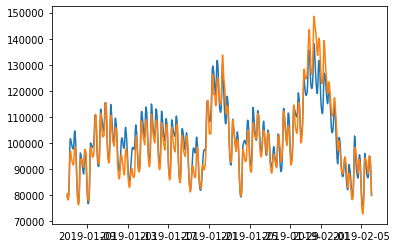

In [7]:
plt.plot(y_test)

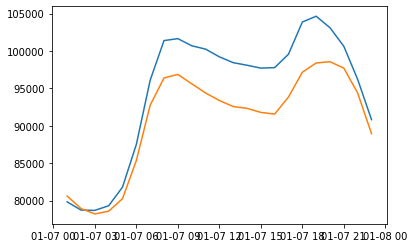

In [11]:
plt.plot(y_test['20190107'])